In [2]:
import scanpy as sc
from datasets.preprocess import preprocess_scRNA, preprocess_ADT

# Read the h5ad file created from Seurat
protein_data = preprocess_scRNA("../datasets/data/processed/LUNG-CITE_RNA.h5ad", h5ad_out="./datasets/data/processed/LUNG-CITE/RNA.h5ad")
rna_data = preprocess_ADT("../datasets/data/processed/LUNG-CITE_ADT.h5ad", h5ad_out="./datasets/data/processed/LUNG-CITE/ADT.h5ad")

print(protein_data)
print(rna_data)

C:\Users\wzy66\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
C:\Users\wzy66\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
C:\Users\wzy66\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 10470 × 300
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 10470 × 52
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
    var: 'count', 'percentile', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_apca', 'X_pca'
    varm: 'APCA', 'PCs'


In [3]:
import scanpy as sc

modalities = ["ADT", "RNA"]

data = {}

for modality in modalities:
    data[modality] = sc.read_h5ad(f"./datasets/data/processed/LUNG-CITE/{modality}.h5ad")

data

{'ADT': AnnData object with n_obs × n_vars = 10470 × 52
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
     var: 'count', 'percentile', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mean', 'std'
     uns: 'pca'
     obsm: 'X_apca', 'X_pca'
     varm: 'APCA', 'PCs',
 'RNA': AnnData object with n_obs × n_vars = 10470 × 300
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg', 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'}

In [4]:
import torch

processed = {m: {'x': torch.tensor(data[m].X, dtype=torch.float)} for m in modalities}
processed

{'ADT': {'x': tensor([[-0.0974,  0.2393, -0.3813,  ...,  0.0546,  0.7930,  1.7776],
          [-0.0711,  0.6933,  0.1117,  ...,  2.8325,  0.1630, -0.2396],
          [ 0.1550, -0.1360, -0.0720,  ..., -0.8201, -0.0202, -0.7624],
          ...,
          [-0.2282,  0.4738,  0.4169,  ...,  0.1767, -1.0651,  0.5179],
          [-0.3123, -1.4328, -0.3951,  ...,  0.0395,  0.2566,  1.4655],
          [-0.4883,  0.5339, -1.1179,  ...,  0.9030, -1.0651,  0.6029]])},
 'RNA': {'x': tensor([[ 0.4597,  0.5207,  0.5217,  ...,  0.4711,  0.5247,  0.5179],
          [-1.1429, -1.2798, -1.4041,  ..., -1.1543, -1.4377, -1.4017],
          [ 0.0660,  0.1409,  0.1827,  ...,  0.0741,  0.1894,  0.1727],
          ...,
          [ 2.0709,  1.9522,  1.7269,  ...,  2.0888,  1.7085,  1.7516],
          [-0.2079, -0.1376, -0.0768,  ..., -0.2027, -0.0687, -0.0904],
          [ 1.4860,  1.4463,  1.3087,  ...,  1.5023,  1.2986,  1.3228]])}}

In [5]:
from torch_geometric.data import HeteroData

# (1) Assign attributes after initialization,
data = HeteroData(processed)
data['cell'].x = torch.cat([data[m].x for m in modalities], dim=1)
data

HeteroData(
  ADT={ x=[10470, 52] },
  RNA={ x=[10470, 300] },
  cell={ x=[10470, 352] }
)

In [6]:
from torch_geometric.nn import knn_graph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

for m in modalities:
    data['cell', m, 'cell'].edge_index = knn_graph(
        data[m].x,
        k=10,
        cosine=True,
        num_workers=16
    )

In [7]:
data

HeteroData(
  ADT={ x=[10470, 52] },
  RNA={ x=[10470, 300] },
  cell={ x=[10470, 352] },
  (cell, ADT, cell)={ edge_index=[2, 104700] },
  (cell, RNA, cell)={ edge_index=[2, 104801] }
)

In [8]:
import torch
from torch_geometric.loader import NeighborLoader

# Assume 'data' is your HeteroData instance and the number of cell nodes is available via:
num_cells = data['cell'].x.size(0)  # or data['cell'].num_nodes if set

# Create indices for all cells:
cell_idx = torch.arange(num_cells)

# Create a NeighborLoader that samples neighborhoods for 'cell' nodes.
# Here, we specify how many neighbors to sample for each edge type.
neighbor_loader = NeighborLoader(
    data,
    num_neighbors={
        ('cell', 'ADT', 'cell'): [10, 10],  # sample 10 neighbors for 2 layers (example)
        ('cell', 'RNA', 'cell'): [10, 10]
    },
    input_nodes=('cell', cell_idx),
    batch_size=1024  # choose an appropriate batch size for your memory constraints
)

for batch in neighbor_loader:
    print(batch)

HeteroData(
  ADT={
    x=[0, 52],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  RNA={
    x=[0, 300],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  cell={
    x=[10413, 352],
    n_id=[10413],
    num_sampled_nodes=[3],
    input_id=[1024],
    batch_size=1024,
  },
  (cell, ADT, cell)={
    edge_index=[2, 83900],
    e_id=[83900],
    num_sampled_edges=[2],
  },
  (cell, RNA, cell)={
    edge_index=[2, 83900],
    e_id=[83900],
    num_sampled_edges=[2],
  }
)
HeteroData(
  ADT={
    x=[0, 52],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  RNA={
    x=[0, 300],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  cell={
    x=[10396, 352],
    n_id=[10396],
    num_sampled_nodes=[3],
    input_id=[1024],
    batch_size=1024,
  },
  (cell, ADT, cell)={
    edge_index=[2, 83590],
    e_id=[83590],
    num_sampled_edges=[2],
  },
  (cell, RNA, cell)={
    edge_index=[2, 83590],
    e_id=[83590],
    num_sampled_edges=[2],
  }
)
HeteroData(
  ADT={
    x=[0, 52],
    n_id=[0],
    num_s

In [10]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch_geometric.nn import HeteroConv, GCNConv
from torch_geometric.utils import negative_sampling

# Heterogeneous Graph Autoencoder model (without variational reparameterization).
class HeteroGraphAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels, modalities, num_layers=2, **kwargs):
        super().__init__()
        # First heterogeneous convolution layer.
        self.conv1 = HeteroConv({
            ('cell', m, 'cell'): GCNConv(in_channels, hidden_channels) for m in modalities
        }, aggr='sum')
        self.bn1 = nn.ModuleDict({'cell': nn.BatchNorm1d(hidden_channels)})

        # Intermediate layers (if num_layers > 1).
        self.layers = nn.ModuleList([
            HeteroConv({
                ('cell', m, 'cell'): GCNConv(hidden_channels, hidden_channels) for m in modalities
            }, aggr='sum')
            for _ in range(num_layers - 1)
        ])
        self.bn_layers = nn.ModuleList([
            nn.ModuleDict({'cell': nn.BatchNorm1d(hidden_channels)}) for _ in range(num_layers - 1)
        ])

        # Single heterogeneous convolution to compute the latent representation.
        self.z_conv = HeteroConv({
            ('cell', m, 'cell'): GCNConv(hidden_channels, latent_channels) for m in modalities
        }, aggr='sum')

    def encode(self, data):
        x_dict = {'cell': data['cell'].x}
        # First layer: conv -> batch norm -> activation.
        x_dict = self.conv1(x_dict, data.edge_index_dict)
        x_dict = {k: self.bn1[k](x) for k, x in x_dict.items()}
        x_dict = {k: F.silu(x) for k, x in x_dict.items()}

        # Intermediate layers.
        for bn_layer, layer in zip(self.bn_layers, self.layers):
            x_dict = layer(x_dict, data.edge_index_dict)
            x_dict = {k: bn_layer[k](x) for k, x in x_dict.items()}
            x_dict = {k: F.silu(x) for k, x in x_dict.items()}

        # Compute the latent representation.
        z_dict = self.z_conv(x_dict, data.edge_index_dict)
        return z_dict

    def decode(self, z, edge_index):
        # Dot-product decoder: compute similarity scores for given edges.
        z_src = z[edge_index[0]]
        z_dst = z[edge_index[1]]
        return torch.sigmoid((z_src * z_dst).sum(dim=1))

    def forward(self, data):
        z_dict = self.encode(data)
        z = z_dict['cell']
        return z

# LightningModule for training the Autoencoder with a warm-up cosine decay scheduler.
class GraphAELightningModule(pl.LightningModule):
    def __init__(self, in_channels, hidden_channels, latent_channels, modalities, num_layers, learning_rate, total_epochs, warmup_epochs=5):
        super().__init__()
        self.save_hyperparameters(ignore=['modalities'])
        self.total_epochs = total_epochs
        self.warmup_epochs = warmup_epochs

        self.model = HeteroGraphAE(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            latent_channels=latent_channels,
            modalities=modalities,
            num_layers=num_layers
        )
        self.learning_rate = learning_rate

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        # Obtain latent embeddings.
        z = self.model(batch)

        # Aggregate positive edges from all 'cell'–to–'cell' relations.
        pos_edge_list = []
        for key, edge_index in batch.edge_index_dict.items():
            if key[0] == 'cell' and key[2] == 'cell':
                pos_edge_list.append(edge_index)
        if len(pos_edge_list) == 0:
            raise ValueError("No 'cell'-to-'cell' edges found in data.edge_index_dict.")
        pos_edge_index = torch.cat(pos_edge_list, dim=1)

        # Sample negative edges.
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=z.size(0),
            num_neg_samples=pos_edge_index.size(1)
        )

        # Compute predictions for positive and negative edges.
        pos_pred = self.model.decode(z, pos_edge_index)
        neg_pred = self.model.decode(z, neg_edge_index)
        preds = torch.cat([pos_pred, neg_pred], dim=0)
        labels = torch.cat([torch.ones_like(pos_pred), torch.zeros_like(neg_pred)], dim=0)
        recon_loss = F.binary_cross_entropy(preds, labels)

        # For a standard autoencoder, the loss is solely the reconstruction loss.
        loss = recon_loss
        batch_size = batch['cell'].x.size(0)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        def lr_lambda(current_epoch):
            if current_epoch < self.warmup_epochs:
                # Linear warm-up.
                return float(current_epoch) / float(max(1, self.warmup_epochs))
            else:
                # Cosine decay.
                progress = (current_epoch - self.warmup_epochs) / float(max(1, self.total_epochs - self.warmup_epochs))
                return 0.5 * (1.0 + math.cos(math.pi * progress))

        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1,
            }
        }

# Hyperparameters.
in_channels = 352
hidden_channels = 512
latent_channels = 512   # Dimensionality of the latent space.
num_layers = 4
learning_rate = 1e-3
n_epochs = 500

# Ensure that `modalities` and your dataloader (e.g., neighbor_loader) are defined.
# For example:
# modalities = ['modality1', 'modality2']
# neighbor_loader = your_dataloader_object

# Instantiate the Lightning module.
model = GraphAELightningModule(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    latent_channels=latent_channels,
    modalities=modalities,
    num_layers=num_layers,
    learning_rate=learning_rate,
    total_epochs=n_epochs,
    warmup_epochs=10
)

if __name__ == '__main__':
    from pytorch_lightning import Trainer
    from pytorch_lightning.callbacks import EarlyStopping

    early_stop_callback = EarlyStopping(
        monitor='train_loss',
        min_delta=0.005,
        patience=5,
        verbose=True,
        mode='min'
    )

    trainer = Trainer(
        max_epochs=n_epochs,
        accelerator="gpu",
        devices=1,
        callbacks=[early_stop_callback]
    )
    trainer.fit(model, train_dataloaders=neighbor_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | HeteroGraphAE | 2.5 M  | train
------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.867     Total estimated model params size (MB)
51        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 33.588
Metric train_loss improved by 7.332 >= min_delta = 0.005. New best score: 26.256
Metric train_loss improved by 4.810 >= min_delta = 0.005. New best score: 21.447
Metric train_loss improved by 6.683 >= min_delta = 0.005. New best score: 14.763
Metric train_loss improved by 8.713 >= min_delta = 0.005. New best score: 6.050
Metric train_loss improved by 3.331 >= min_delta = 0.005. New best score: 2.719
Metric train_loss improved by 1.449 >= min_delta = 0.005. New best score: 1.270
Metric train_loss improved by 0.398 >= min_delta = 0.005. New best score: 0.872
Metric train_loss improved by 0.130 >= min_delta = 0.005. New best score: 0.742
Metric train_loss improved by 0.087 >= min_delta = 0.005. New best score: 0.655
Metric train_loss improved by 0.008 >= min_delta = 0.005. New best score: 0.647
Metric train_loss improved by 0.009 >= min_delta = 0.005. New best score: 0.638
Metric train_loss improved by 0.013 >= min_delta = 0.005. New best

In [11]:

# Inference on full data:
model.eval()
with torch.no_grad():
    # Move data to the same device as the model.
    data = data.to(model.device)
    z = model(data)
    # For example, reconstruct edge probabilities using one set of edges.
    pos_edge_index = list(data.edge_index_dict.values())[0]
    pred_edge_probs = model.model.decode(z, pos_edge_index)
    print(f"nde_embedding: {z}")
    print("Predicted edge probabilities:", pred_edge_probs)


nde_embedding: tensor([[-0.0424, -0.0017, -0.1020,  ..., -0.0490,  0.1049, -0.0854],
        [ 0.1048, -0.0412,  0.1199,  ...,  0.0537, -0.1278,  0.0424],
        [-0.0366,  0.0752, -0.0412,  ..., -0.1309, -0.0388, -0.0063],
        ...,
        [-0.0184,  0.0795, -0.1390,  ...,  0.1391, -0.0465, -0.0607],
        [ 0.0616, -0.0747,  0.0211,  ...,  0.0147,  0.0905, -0.0004],
        [ 0.0270,  0.0627, -0.1027,  ...,  0.1588,  0.1191, -0.0736]])
Predicted edge probabilities: tensor([0.8919, 0.7468, 0.7956,  ..., 0.9410, 0.8466, 0.9906])


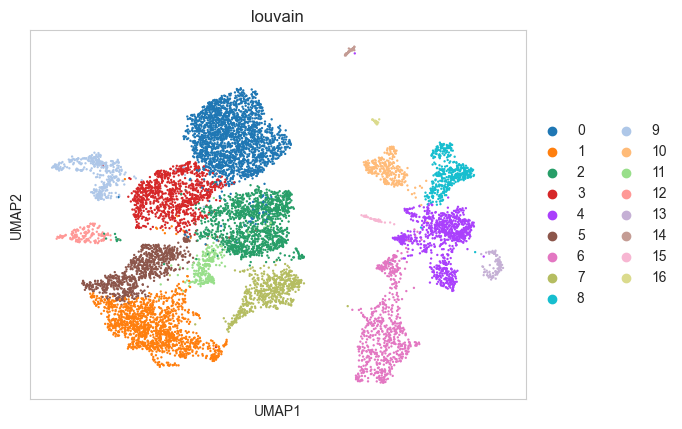

In [12]:
protein_data.obsm["emb"] = z.detach().cpu().numpy()
# protein_data.obsm["emb"] = data['cell'].x.detach().cpu().numpy()
sc.pp.neighbors(protein_data, use_rep='emb')
sc.tl.louvain(protein_data, resolution=0.5)
sc.tl.umap(protein_data)
sc.pl.embedding(protein_data, color='louvain', basis='umap')